In [11]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# extract dense SIFT descriptors + their (x,y) locations
def extract_dense_sift(image, step_size=8, bin_size=16):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    # sample keypoints on a regular grid
    kps = [cv2.KeyPoint(x, y, bin_size)
           for y in range(0, gray.shape[0], step_size)
           for x in range(0, gray.shape[1], step_size)]
    _, descriptors = sift.compute(gray, kps)
    locations = np.array([kp.pt for kp in kps])
    return descriptors, locations

In [14]:
# learn a visual‐vocabulary (codebook) via KMeans
def build_codebook(descriptors, vocab_size=100):
    kmeans = MiniBatchKMeans(
        n_clusters=vocab_size,
        batch_size=vocab_size*20,
        random_state=0
    )
    kmeans.fit(descriptors)
    return kmeans


In [15]:
# compute the SPM feature vector
def spatial_pyramid_matching(image, descriptors, locations, kmeans, levels=2):
    h, w = image.shape[:2]
    words = kmeans.predict(descriptors)
    all_hist = []

    # weight scheme: level 0 gets 1/2^L, others get 1/2^{L−l+1}
    for l in range(levels+1):
        num_cells = 2**l
        w_cell, h_cell = w/num_cells, h/num_cells
        weight = (1/(2**levels)) if l==0 else (1/(2**(levels-l+1)))

        for i in range(num_cells):
            for j in range(num_cells):
                # cell bounds
                x0, x1 = i*w_cell, (i+1)*w_cell
                y0, y1 = j*h_cell, (j+1)*h_cell
                # select descriptors in this cell
                idx = np.where(
                    (locations[:,0]>=x0)&(locations[:,0]<x1)&
                    (locations[:,1]>=y0)&(locations[:,1]<y1)
                )[0]
                hist, _ = np.histogram(
                    words[idx],
                    bins=np.arange(kmeans.n_clusters+1),
                    density=False
                )
                # normalize histogram
                if hist.sum()>0:
                    hist = hist.astype(float)/hist.sum()
                all_hist.append(weight*hist)

    return np.hstack(all_hist)

In [20]:
def histogram_intersection(h1, h2):
    return np.sum(np.minimum(h1, h2))

In [28]:
path_1 = "/content/drive/My Drive/xiaobao/test_data/img1.ppm"
path_2 = "/content/drive/My Drive/xiaobao/test_data/img5.ppm"
img1 = cv2.imread(path_1)
img2 = cv2.imread(path_2)

# Extract SIFT descriptors and locations
desc1, locs1 = extract_dense_sift(img1)
desc2, locs2 = extract_dense_sift(img2)

# Build a shared codebook
all_descs = np.vstack([desc1, desc2])
kmeans = build_codebook(all_descs, vocab_size=100)

# Compute SPM features
feat1 = spatial_pyramid_matching(img1, desc1, locs1, kmeans, levels=2)
feat2 = spatial_pyramid_matching(img2, desc2, locs2, kmeans, levels=2)

# Compute similarity
sim_score = histogram_intersection(feat1, feat2)
print(f"SPM Histogram Intersection Similarity: {sim_score:.4f}")

SPM Histogram Intersection Similarity: 1.4619


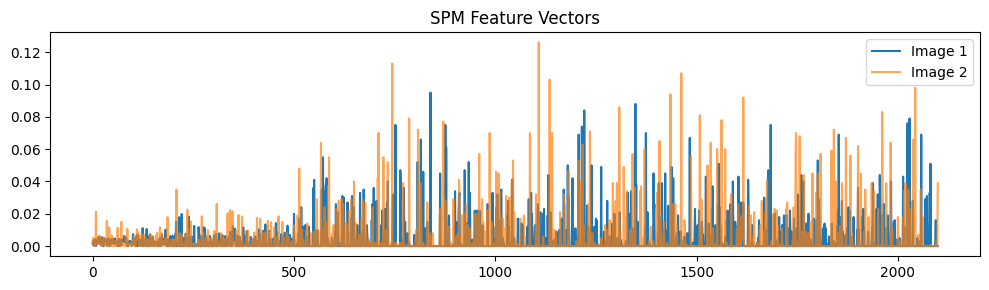

In [29]:
plt.figure(figsize=(10,3))
plt.plot(feat1, label="Image 1")
plt.plot(feat2, label="Image 2", alpha=0.7)
plt.legend()
plt.title("SPM Feature Vectors")
plt.tight_layout()
plt.show()

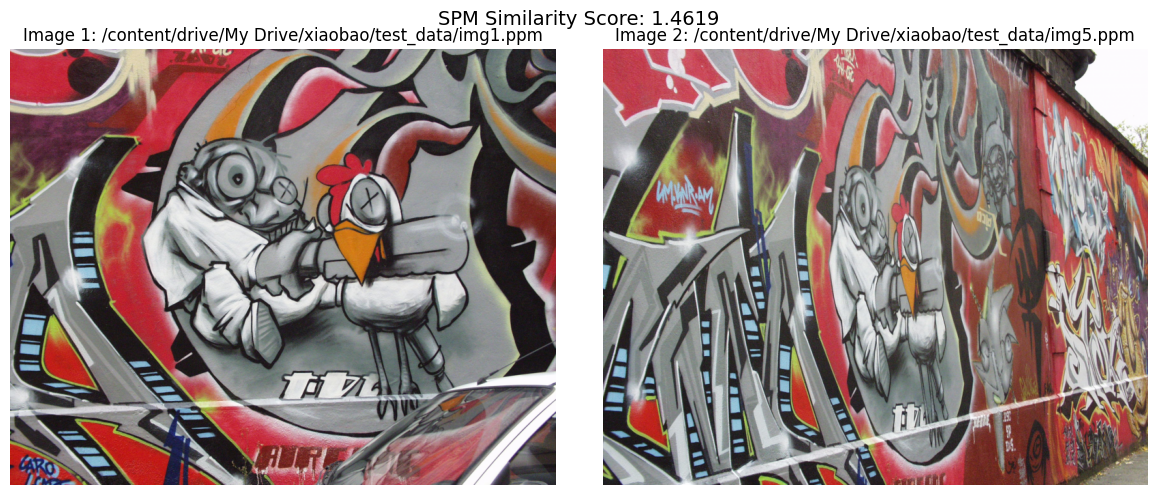

In [30]:
# Convert BGR (OpenCV default) to RGB for correct color display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plot side by side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title(f'Image 1: {path_1}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title(f'Image 2: {path_2}')
plt.axis('off')

plt.suptitle(f'SPM Similarity Score: {sim_score:.4f}', fontsize=14)
plt.tight_layout()
plt.show()